In [1]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings, AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
from supabase import create_client
#from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.output_parsers import StrOutputParser
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.schema import Document
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Literal
from typing import List
from typing_extensions import TypedDict
from langchain.tools.retriever import create_retriever_tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from pprint import pprint
from typing import Any,  Literal, Union, Optional,Callable
from langchain_core.messages import  AnyMessage
from langchain.schema import AIMessage
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import ToolMessage
import logging
import os
import load_data

Supabase client initialized: <supabase._sync.client.SyncClient object at 0x000001D97EF40D40>


In [2]:
#Inicialización variables
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_ENDPOINT=os.getenv("AZURE_OPENAI_ENDPOINT")
OPENAI_API_VERSION=os.getenv("OPENAI_API_VERSION")

vector_store=load_data.load_vector_store()
retriever=vector_store.as_retriever(search_kwargs={"k":1})
chat= AzureChatOpenAI(azure_deployment="gpt-4o-rfmanrique")

In [3]:

class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the student's needs."""

    cancel: bool =True
    reason: str

#Prompt feedback 
system = """

"Eres un tutor de programación encargado de brindar retroalimentación formativa a estudiantes del curso de introducción a la programación, quienes estan aprendiendo python. 
Tu vas a recibir toda la información del problema que se quiere revisar. 

No escribas bloques de código de ejemplo. No escribas una versión corregida o actualizada del código del estudiante. 
No debes escribir código para el estudiante. ¿Cómo responderías al estudiante para guiarlo y explicar conceptos sin proporcionar un ejemplo de código?"

La información consiste en :
1. Descripción del problema :
{problem_description}
2. Parametros de entrada:
{parameter_description} 
3. Retorno 
{return_description}
4. Funciones y primitivas prohibidas :
{primitives_forbiden_description}

La solución del estudiante no puede contener ninguna de las funciones y primitivas prohibidas. 

Los estudiantes proporcionarán el codigo de la solución : 
{user_input}

Si el user_input del usuario no es codigo, responde con un error diciendole que debe proveer el codigo del solución que tiene planeada. Debes ser simple y directo

Si el user_input es codigo, entonces: 
Analiza el codigo proporcionado por el usuario, y responde con una explicacion educativa, ayudando al estudiante a descubrir los problemas con su solución. 
Si la solución no presenta errores, dile al ususario que lo hizo muy bien. Se simple y conciso con tu respuesta


Asegurate de que la retroalimentación sea constructiva y fácil de entender, evitando cualquier tipo de critica negativa y enfocandote en como el estudiante puede aprender y mejorar

¡Sé positivo y alentador! Utiliza el formato Markdown, incluyendo ‘ para código en línea.
Primero realiza tu la solución para mirar diferencias con la solución que te manda el estudiante.

Recuerda que no puedes escribir bloques de codigo.


"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("placeholder","{messages}")
    ]
)

feedback_agent=prompt | chat.bind_tools([CompleteOrEscalate])

descripcion="""

En una estación de Transmilenio los operarios usan una fórmula matemática sencilla para saber si deben o no despachar un bus nuevo. Para esto tienen un contador de pasajeros en el bus entrante (personas_bus) y un contador de personas paradas en la plataforma (personas_estacion).

Los operarios saben que la capacidad teórica máxima del bus es de 150 personas. Sin embargo, también saben que si se aprietan pueden transportar a máximo 200 personas. Los pasajeros no quieren viajar incómodos pero tampoco quieren demorarse mucho tomando el bus, así que sólo se montarán a un bus con sobrecupo que llegue a la estación si hay 40 o más personas en la plataforma. Luego de que el bus se detenga y entren las personas, los operarios decidirán si deben enviar un bus adicional: enviarán un bus nuevo, si al salir de la estación el bus quedó con sobrecupo o si en la plataforma quedaron 50 o más personas.

Su trabajo es construir una función en Python que le ayude a los operarios de Transmilenio a tomar la decisión de despachar o no un bus nuevo.

"""

parametros=[
    {"nombre" : "personas_bus", "tipo" : "int", "descripcion" : "Numero de personas en el bus que va a detenerse"},
    {"nombre" : "personas_estacion", "tipo" : "int", "descripcion" : "Numero de personas esperando el bus de la estación"} 
]

retorno={"tipo":"bool", "descripcion": "Retorna el valor True si se debe despachar un bus nuevo y retorna False de lo contrario."}

primitivas=[{"nombre":"for" ,"descripcion":"No deberia usar la primitiva for para resolver este problema", "nombre" : "while", "descripcion": "No deberia usar la primitiva while para resolver este problema"}]



#solucion="cual es el modelo que estas usando"
solucion2="""
def despacho_buses(personas_bus: int, personas_estacion: int)->bool:
    despachar_bus = False
    sobrecupo = personas_bus > 150
    if sobrecupo and personas_estacion >= 40:
      despachar_bus = True
      
    capacidad = 200 - personas_bus
    
    if capacidad < personas_estacion:
      personas_estacion -= capacidad
      personas_bus += capacidad
    else:
      personas_bus += personas_estacion
      personas_estacion = 0
    if personas_bus > 150 or personas_estacion >=50:
      despachar_bus = True
      
    return despachar_bus
"""
solucion1="""
def despacho_buses(personas_bus: int, personas_estacion: int)->bool:

    # Definimos las constantes
    return True
"""

# Prompt rag

chat= AzureChatOpenAI(azure_deployment="gpt-4o-rfmanrique")



system="""
You are a specialized assistant for Answering conceptual doubts about the "introduction to programming course" 
The main assistant delegates work to you whenever the student needs conceptual help.
If the student changes their mind, escalate the task back to the main assistant.
Your main function is to answer conceptual doubts/inquiries that students may have about the different modules of the course. The course is compound of 4 modules:

Module 1 :  Introduction to programming
In this module, students learn about the fundaments of programming.
Module 2 : Conditions
Students learn conditional structures like if, elif and else. Boolean algebra.
Module 3 : Loops
Students learn about for and while 
Module 4 : Pandas
Students learn to use external libraries, like pandas.

To answer the student doubts, you will have the following context taken from a programming book :

{context}

Try to explain the concepts in the most briefly way. If the student wants to emphasize in a particular item, proceed. 
The student is on the level : {level}

Use markdown format, including ‘ for online coding
Student input : {user_input}
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),      
        ("placeholder","{messages}")
    ]
)

conceptual_agent=prompt|chat.bind_tools([CompleteOrEscalate])

#Prompt  Question re-writer

system = """
Eres un reformulador de preguntas que convierte una pregunta de entrada en una versión mejorada, optimizada para la búsqueda en una vector store. 
Observa la entrada y trata de razonar sobre la intención o significado semántico subyacente. La vector store trata tema sobre introducción a la programación.
En algunas ocasiones el estudiante hará follow-up questions, por lo que debes reformularla basado en los mensajes anteriores para que pueda entrar a la vector store.
Debes ser simple y conciso.

La pregunta es : {user_input}
"""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("placeholder","{messages}"),
    ]
)
chat= AzureChatOpenAI(azure_deployment="gpt-4o-rfmanrique")

question_rewriter = re_write_prompt | chat  

#Main assistant 
chat= AzureChatOpenAI(azure_deployment="gpt-4o-rfmanrique")
class toConceptualAssistant(BaseModel):
    """
    Transfers work to a specialized assistant  to handle any conceptual doubts/inquiries about the programming course. The doubts must be about programming
    """
    request: str=Field(description="Any necessary follow-up questions the conceptual assistant  should clarify  before proceeding. The questions must be about programming. ")

class toFeedbackAssistant(BaseModel):
    """
    Transfers work to a specialized assistant to give detailed feedback about a code problem
    """
    code : str=Field(description="The code block which the student wants to get feedback from")
    name : str=Field(description= "The name of the coding problem which the student wants to get feedback from")

system = """
You are a helpful teaching assistant for the introducion to programming class. 
Your primary role is to welcome the student and introduce them your main capabilities.
Your main capabilities are : Give feedback to students about a code submission of a problem in Senecode, the course main platform;
and Assist the user with any conceptual doubts he has about the programming course. 
The conceptual doubts the student may have are from the topics :  Variables, operator, conditionals, boolean algebra, loops, external libraries
Only the specialized assistants are given permission  to do this for the student.
The student is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. 
Only do functions calls when the user input is not enough to know which tool to use
Be simple and concise with your conversations.

"""

primary_assistant_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("placeholder","{messages}"),
        ("human", "Student input : {user_input}" ),
        ("system", "if the student input is not related to programming or your capabilities, dont do function calls. Talk in spanish")
    ]
)

main_assistant = primary_assistant_prompt | chat.bind_tools([toConceptualAssistant,toFeedbackAssistant])

#Utilities


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node
#Graph
def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]




In [4]:
class State(TypedDict):
    messages:Annotated[list,add_messages]
    dialog_state : Annotated[
        list[
            Literal[
                "main_assistant",
                "feedback_assistant",
                "conceptual_assistant"
            ]
        ],update_dialog_stack
    ]
    level : str 

graph_builder=StateGraph(State)
#memory = SqliteSaver.from_conn_string(":memory:")
memory = MemorySaver()



In [5]:
def senecode_assistant(state:State):
    message=feedback_agent.invoke(
    {"problem_description":descripcion,"parameter_description":parametros,
    "return_description":retorno, "primitives_forbiden_description":primitivas,"user_input":state["messages"][-1], "messages":state["messages"]})

    return {"messages": [message]}
def conceptual_assistant(state:State):
    user_input=state['messages'][-2].additional_kwargs
    #Reformula pregunta para vector store
    query=question_rewriter.invoke({"user_input": user_input, "messages":state["messages"]}).content

    #Extrae contexto segun el query
    context=retriever.invoke(query)

    #Responde de acuerdo al contexto
    response=conceptual_agent.invoke({"user_input":user_input,"messages":state["messages"],"context":context,"level":state["level"]})
    return {"messages": [response]}

In [6]:
def primary_assistant(state:State):
    user_input=state['messages'][-1]
    message=main_assistant.invoke({"user_input":user_input})

    return {"messages": [message]}

def route_primary_assistant(
    state: State,
) -> Literal[
    "enter_conceptual_assistant",
    "enter_feedback_assistant",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == toConceptualAssistant.__name__:
            return "enter_conceptual_assistant"
        elif tool_calls[0]["name"] == toFeedbackAssistant.__name__:
            return "enter_feedback_assistant"
    raise ValueError("Invalid route")

def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "conceptual_assistant",
    "feedback_assistant",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]
#Por el momento se usara uno en conjunto apra feedback y conceptual
def route_assistants(
    state: State,
) -> Literal[
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"

# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the student as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


In [7]:
graph_builder.add_conditional_edges(START,route_to_workflow)
graph_builder.add_node("primary_assistant",primary_assistant)


graph_builder.add_node("enter_conceptual_assistant",create_entry_node("Conceptual Programming assistant","conceptual_assistant"))
graph_builder.add_node("conceptual_assistant",conceptual_assistant)
graph_builder.add_edge("enter_conceptual_assistant", "conceptual_assistant")

graph_builder.add_node("enter_feedback_assistant",create_entry_node("Feedback assistant","feedback_assistant"))
graph_builder.add_node("feedback_assistant",senecode_assistant)
graph_builder.add_edge("enter_feedback_assistant", "feedback_assistant")

graph_builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    {
        "enter_conceptual_assistant": "enter_conceptual_assistant",
        "enter_feedback_assistant": "enter_feedback_assistant",
        END: END,
    },
)
graph_builder.add_conditional_edges("conceptual_assistant", route_assistants)
graph_builder.add_conditional_edges("feedback_assistant",route_assistants)
graph_builder.add_node("leave_skill",pop_dialog_state)
graph_builder.add_edge("leave_skill", "primary_assistant")

In [8]:
graph = graph_builder.compile(checkpointer=memory)

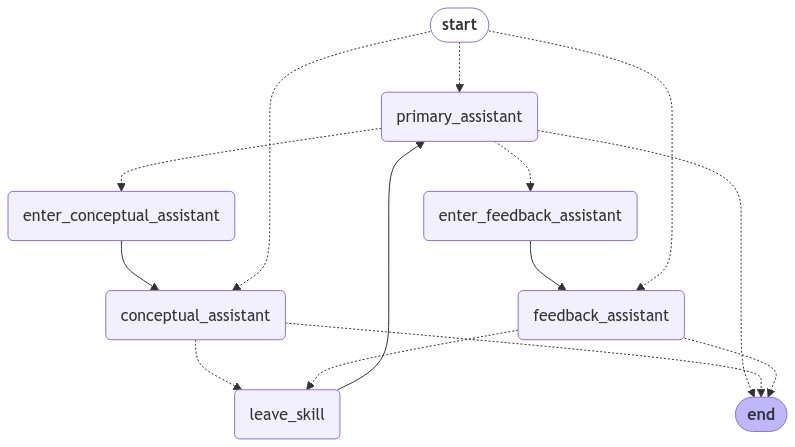

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
config={"configurable":{"thread_id":11}}
lista=["explicame condicionales"]
for i in lista:
    for event in graph.stream({"messages": ("user", i),"level":2},config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


Assistant: 
Assistant: The assistant is now the Conceptual Programming assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are Conceptual Programming assistant, If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control. Do not mention who you are - just act as the proxy for the assistant.
Assistant: Las estructuras condicionales permiten que tu programa tome decisiones basadas en ciertas condiciones. En este contexto, te explicaré los conceptos básicos de las estructuras condicionales en Python.

### Condicionales en Python

1. **if**:
   La estructura `if` permite ejecutar un bloque de código solo si una condición es verdadera.

   ```python
   if condicion:
       # bloque de código
   ```

2. **else**:
   La estructura `else` se usa junto con `if` para ejecutar un bloque de